In [1]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle


Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [2]:
# @param Does it save the figure ?
save_fig    = False
save_folder = 'UC2_fig'

# @param Connexion à la DB
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')


# @param Definition des table et colonnes --> Dépendent de la DB
DB             = "Archive2018_2019_prod"
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

Univers_Depth  = 3            # Jusqu'où on ira dans l'univers ? = [1;4]

# @param Variable influançant la sélection des données
nbr_client     = -1           # Nombre de clients à sélectionner. MAX = 148188. -1 --> ALL
client_tresh   = 15           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 15           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = True         # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 14           # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 50           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = False        # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse


# @param Hierchaical/Agglomerative Clustering
max_fitted = 10000
method     = 'ward'            # types de méthode: ward complete average single
 
# @param PCA
threeD         = False         # Afficher le graphe 3D dans les projection PCA
nbr_dim_keep   = 20            # Nombre de dimension gardée lors du KMeans effectué après un PCA    
K_PCA          = K             # K pour KMeans après le PCA

In [3]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_CONSO+".KEY] FROM ["+DB+"].[DWH].[Dim_"+TABLE_CONSO+"]", conn)
print(df)

conn.close()

   Consommateur.KEY
0                -1
1                 1
2                 2
3                 3
4                 4
5                 5
6                 6
7                 7
8                 8
9                 9


## LOAD & PREPROCESSING DATA

In [4]:
start = time()

sql_command = '''SELECT [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE + '''.''' + TABLE_CONSO + '''.KEY] AS ''' + TABLE_CONSO + '''
FROM  ['''      + DB + '''].[DWH].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[DWH].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO   + '''.KEY] > 0 
AND   [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388'''
if nbr_client != -1:
    sql_command +=  ''' AND [''' + TABLE_ENTETE  +'''.'''     + TABLE_CONSO   + '''.KEY] < '''  + str(nbr_client)

print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 3min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)

SELECT [Article_meti_HIST.Univers.KEY] AS Univers
,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
FROM  [Archive2018_2019_prod].[DWH].[Fact_Recette_detail_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Fact_Recette_entete_ticket] 
ON    [Recette_detail_ticket.TEMPS.KEY_Date_reel_transaction] = [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] 
AND   [Recette_detail_ticket.Numero_ticket] = [Recette_entete_ticket.Numero_ticket]
INNER JOIN [Archive2018_2019_prod].[DWH].[Dim_Article_meti_HIST]
ON [Recette_detail_ticket.Article_meti_HIST.KEY] = [Article_meti_HIST.KEY] 
WHERE [Recette_entete_ticket.Consommateur.KEY] > 0 
AND   [Article_meti_HIST.Univers.KEY] != 388
Time Taken to load DB: ~324secondes
10715545


In [5]:
start = time()

sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
    [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
    [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']'''
print(sql_command)

conn = engine.connect()
df_my_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 0s
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
print(df_my_univers)

SELECT [Univers.KEY],
    [Univers.Libelle_univers1_FR], 
    [Univers.Libelle_univers2_FR], 
    [Univers.Libelle_univers3_FR], 
    [Univers.Libelle_univers4_FR]
    FROM [Archive2018_2019_prod].[DWH].[Dim_Univers]
Time Taken to load DB: ~0secondes
     Univers.KEY Univers.Libelle_univers1_FR Univers.Libelle_univers2_FR  \
0             -1                           ?                           ?   
1              1               PRET A MANGER      SERVICE TRAITEUR FROID   
2              2               PRET A MANGER                MEUBLE CHAUD   
3              3               PRET A MANGER                MEUBLE CHAUD   
4              4               PRET A MANGER                MEUBLE CHAUD   
..           ...                         ...                         ...   
485          485               PRET A MANGER                     SALADES   
486          486               PRET A MANGER                     SALADES   
487          487  APERITIF   ENTREES   TAPAS                     

In [6]:
univers_correspondance = {}
deleted = set()
for item in df_my_univers.values:
    if item[0] in deleted:
        continue
    for cor in df_my_univers.values: 
        if item[0] != cor[0]:
            if (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
                deleted.add(cor[0])
print(univers_correspondance)

{428: 1, 429: 1, 3: 2, 4: 2, 5: 2, 8: 7, 28: 27, 32: 31, 39: 38, 40: 38, 42: 41, 43: 41, 44: 41, 46: 45, 47: 45, 48: 45, 49: 45, 50: 45, 462: 51, 475: 51, 62: 61, 63: 61, 71: 70, 72: 70, 73: 70, 89: 88, 90: 88, 91: 88, 93: 92, 456: 125, 463: 125, 464: 125, 465: 125, 466: 125, 467: 125, 468: 125, 130: 129, 137: 136, 139: 138, 140: 138, 181: 180, 182: 180, 183: 180, 184: 180, 185: 180, 186: 180, 187: 180, 469: 213, 476: 213, 216: 215, 218: 217, 225: 224, 227: 226, 457: 228, 458: 228, 459: 228, 470: 228, 477: 228, 471: 229, 472: 229, 245: 244, 246: 244, 247: 244, 248: 244, 249: 244, 250: 244, 251: 244, 252: 244, 253: 244, 254: 244, 255: 244, 256: 244, 281: 280, 282: 280, 283: 280, 454: 322, 473: 322, 461: 325, 474: 325, 487: 327, 488: 327, 345: 344, 347: 346, 349: 348, 350: 348, 351: 348, 352: 348, 353: 348, 354: 348, 356: 355, 357: 355, 358: 355, 359: 355, 360: 355, 361: 355, 363: 362, 364: 362, 390: 362, 391: 362, 393: 392, 394: 392, 395: 392, 396: 392, 397: 392, 398: 392, 399: 392, 400

In [7]:
start = time()
dict_client_univ = {}

for i in range(nbr_data):
    univ   = df_univers[TABLE_UNIVERS][i]
    client = df_univers[TABLE_CONSO][i]
    if univ == -1:
        continue
    
    if univ in deleted:
        univ = univers_correspondance[univ]
    
    if not client in dict_client_univ:
        dict_client_univ[client] = {}
        
    if not univ in dict_client_univ[client]:
        dict_client_univ[client][univ] = 0
    dict_client_univ[client][univ] += 1

to_remove = []
for k,v in dict_client_univ.items():
    if sum(v.values()) < client_tresh:
        to_remove.append(k)
    elif not Standard_Norm:
        maxi = max(v.values())
        dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

for k in to_remove:
    del dict_client_univ[k]
        
    
clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                        data = dict_client_univ.values())
clients_data = clients_data.replace(float('NaN'), 0)
 
print(clients_data)

# environ 10s * nbr_client/10.000
print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

             196       215       57        294       405       37        299  \
15979   0.017241  0.051724  0.258621  0.189655  0.241379  0.137931  0.172414   
85263   0.014925  0.000000  0.000000  0.089552  0.000000  0.000000  0.014925   
18836   0.039216  0.000000  0.000000  0.019608  0.352941  0.000000  0.098039   
91072   0.000000  0.000000  0.333333  1.000000  0.000000  0.333333  0.333333   
17754   0.000000  0.051195  0.051195  0.061433  0.020478  0.054608  0.078498   
...          ...       ...       ...       ...       ...       ...       ...   
147307  0.000000  0.000000  0.000000  0.000000  0.800000  0.000000  0.000000   
144712  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000   
144795  0.000000  0.000000  0.500000  0.500000  1.000000  0.000000  0.000000   
144747  0.000000  0.000000  0.000000  0.250000  0.250000  0.000000  0.000000   
144763  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  0.000000   

             64        157       78   .

In [8]:
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

norm_clients_data = clients_data.copy()

if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
if MinMax_Norm:
    norm_clients_data = minmax_normalization(norm_clients_data)
    
if MinMax_Norm or not Standard_Norm: 
    for column in norm_clients_data:
        if sum(norm_clients_data[column]) < univers_tresh:
            norm_clients_data = norm_clients_data.drop(columns = column)

# shuffle rows        
norm_clients_data = shuffle(norm_clients_data) 
# shuffle columns
norm_clients_data = norm_clients_data[shuffle(norm_clients_data.columns)]
print(norm_clients_data)

        158  278  271       224  288       142       244  334       437  267  \
106621  0.0  0.0  0.0  0.000000  0.0  0.000000  0.400000  0.0  0.000000  0.0   
84256   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
37918   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
59002   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.200000  0.0   
75779   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
...     ...  ...  ...       ...  ...       ...       ...  ...       ...  ...   
2110    0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
96071   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.391304  0.0   
18446   0.0  0.0  0.0  0.000000  0.0  0.100000  0.300000  0.0  0.000000  0.0   
75906   0.0  0.0  0.0  0.166667  0.0  0.333333  1.000000  0.0  0.000000  0.0   
14467   0.0  0.0  0.0  0.000000  0.0  0.000000  0.142857  0.0  0.000000  0.0   

        ...  34   312  108  325  155   

# SEGMENTATION DE LA CLIENTELE PAR KMEANS

In [9]:
if do_Analysis:
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [10]:
if do_Analysis:
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(norm_clients_data)
        cluster = model.predict(norm_clients_data)
        cluster_centers = model.cluster_centers_

        treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [11]:
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
cluster = model.labels_
# environ 1s * n_init * K/10
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~65secondes


In [12]:
cluster_centers = model.cluster_centers_

interest = {i:[] for i in range(K)}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(cluster_centers)):
    for j in range(len(cluster_centers[i])):
        if cluster_centers[i][j] > treshold:
            interest[i].append(norm_clients_data.columns[j])

In [13]:
NACK = 0

conn = engine.connect()
for key,values in interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = cluster.tolist().count(key)*100/len(cluster)
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    
    df_libele["Power"] = [round(cluster_centers[key][list(norm_clients_data.columns).index(i)],2) for i in values]
    
    print(df_libele.sort_values("Power", ascending=False).to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 4.56 %
 Univ_KEY          Univ_1             Univ_2             Univ_3  Power
      272 TABACS   PRESSE TABAC   CIGARETTES TABAC   CIGARETTES   0.92


Cluster 1: 6.83 %
 Univ_KEY        Univ_1      Univ_2            Univ_3  Power
      392 PRET A MANGER  SANDWICHES SANDWICHES FROIDS   0.94
      228      BOISSONS SOFT DRINKS              SODA   0.33


Cluster 2: 9.34 %
 Univ_KEY        Univ_1         Univ_2         Univ_3  Power
      405 PRET A MANGER PLATS PREPARES   ITALIAN FOOD   0.96
      403 PRET A MANGER PLATS PREPARES TRADITION FOOD   0.36


Cluster 3: 4.75 %
 Univ_KEY                     Univ_1                    Univ_2 Univ_3  Power
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS    0.9


Cluster 4: 5.64 %
 Univ_KEY         Univ_1                       Univ_2 Univ_3  Power
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS   0.92


Cluster 5: 12.95 %
 Univ_KEY        Univ_1     Univ_2            Univ_3  Power
      392 PRET A MANG

In [14]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~609secondes


# VISUALISATION PCA

In [15]:
def PCA_Visualisation(data, target=[], centroid=[], method = "", threeD = False):
    start = time()

    model_pca = PCA(n_components= 2)
    predict = model_pca.fit(data).transform(data)
    
    
    print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))
    
    plt.figure(figsize=(15, 7))  
    if list(target):
        plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
    else: 
        plt.scatter(predict[:,0],predict[:,1])
    if list(centroid):
        clust_predict = model_pca.transform(centroid)
        plt.scatter(clust_predict[:,0],clust_predict[:,1], color='r')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset - ' + method + ' - Cluster = ' + str(K))

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"-"+method+".jpg")
    
    if threeD:
        model_pca = PCA(n_components= 3)
        predict = model_pca.fit(data).transform(data)
        print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


        plt.figure(figsize=(30, 30)) 
        ax = plt.axes(projection='3d')

        ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target);

        plt.title('PCA of dataset in 3D - ' + method)

        if save_fig:
            plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster_3D-"+str(K)+"-"+method+".jpg")
    
    # environ 1.5s
    print("Time Taken to show PCA : ~" + str(int(time() - start)) + "secondes")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07434054 0.06302172]
Explained variance ratio from PCA: [0.07434054 0.06302172 0.0535689 ]
Time Taken to show PCA : ~1secondes


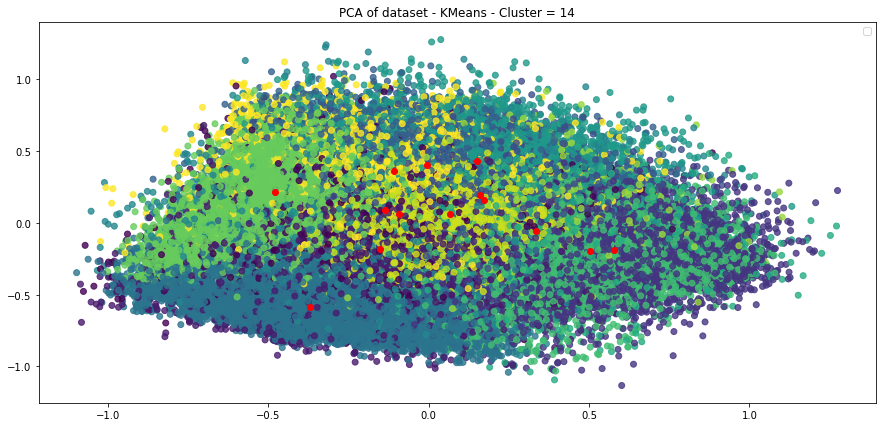

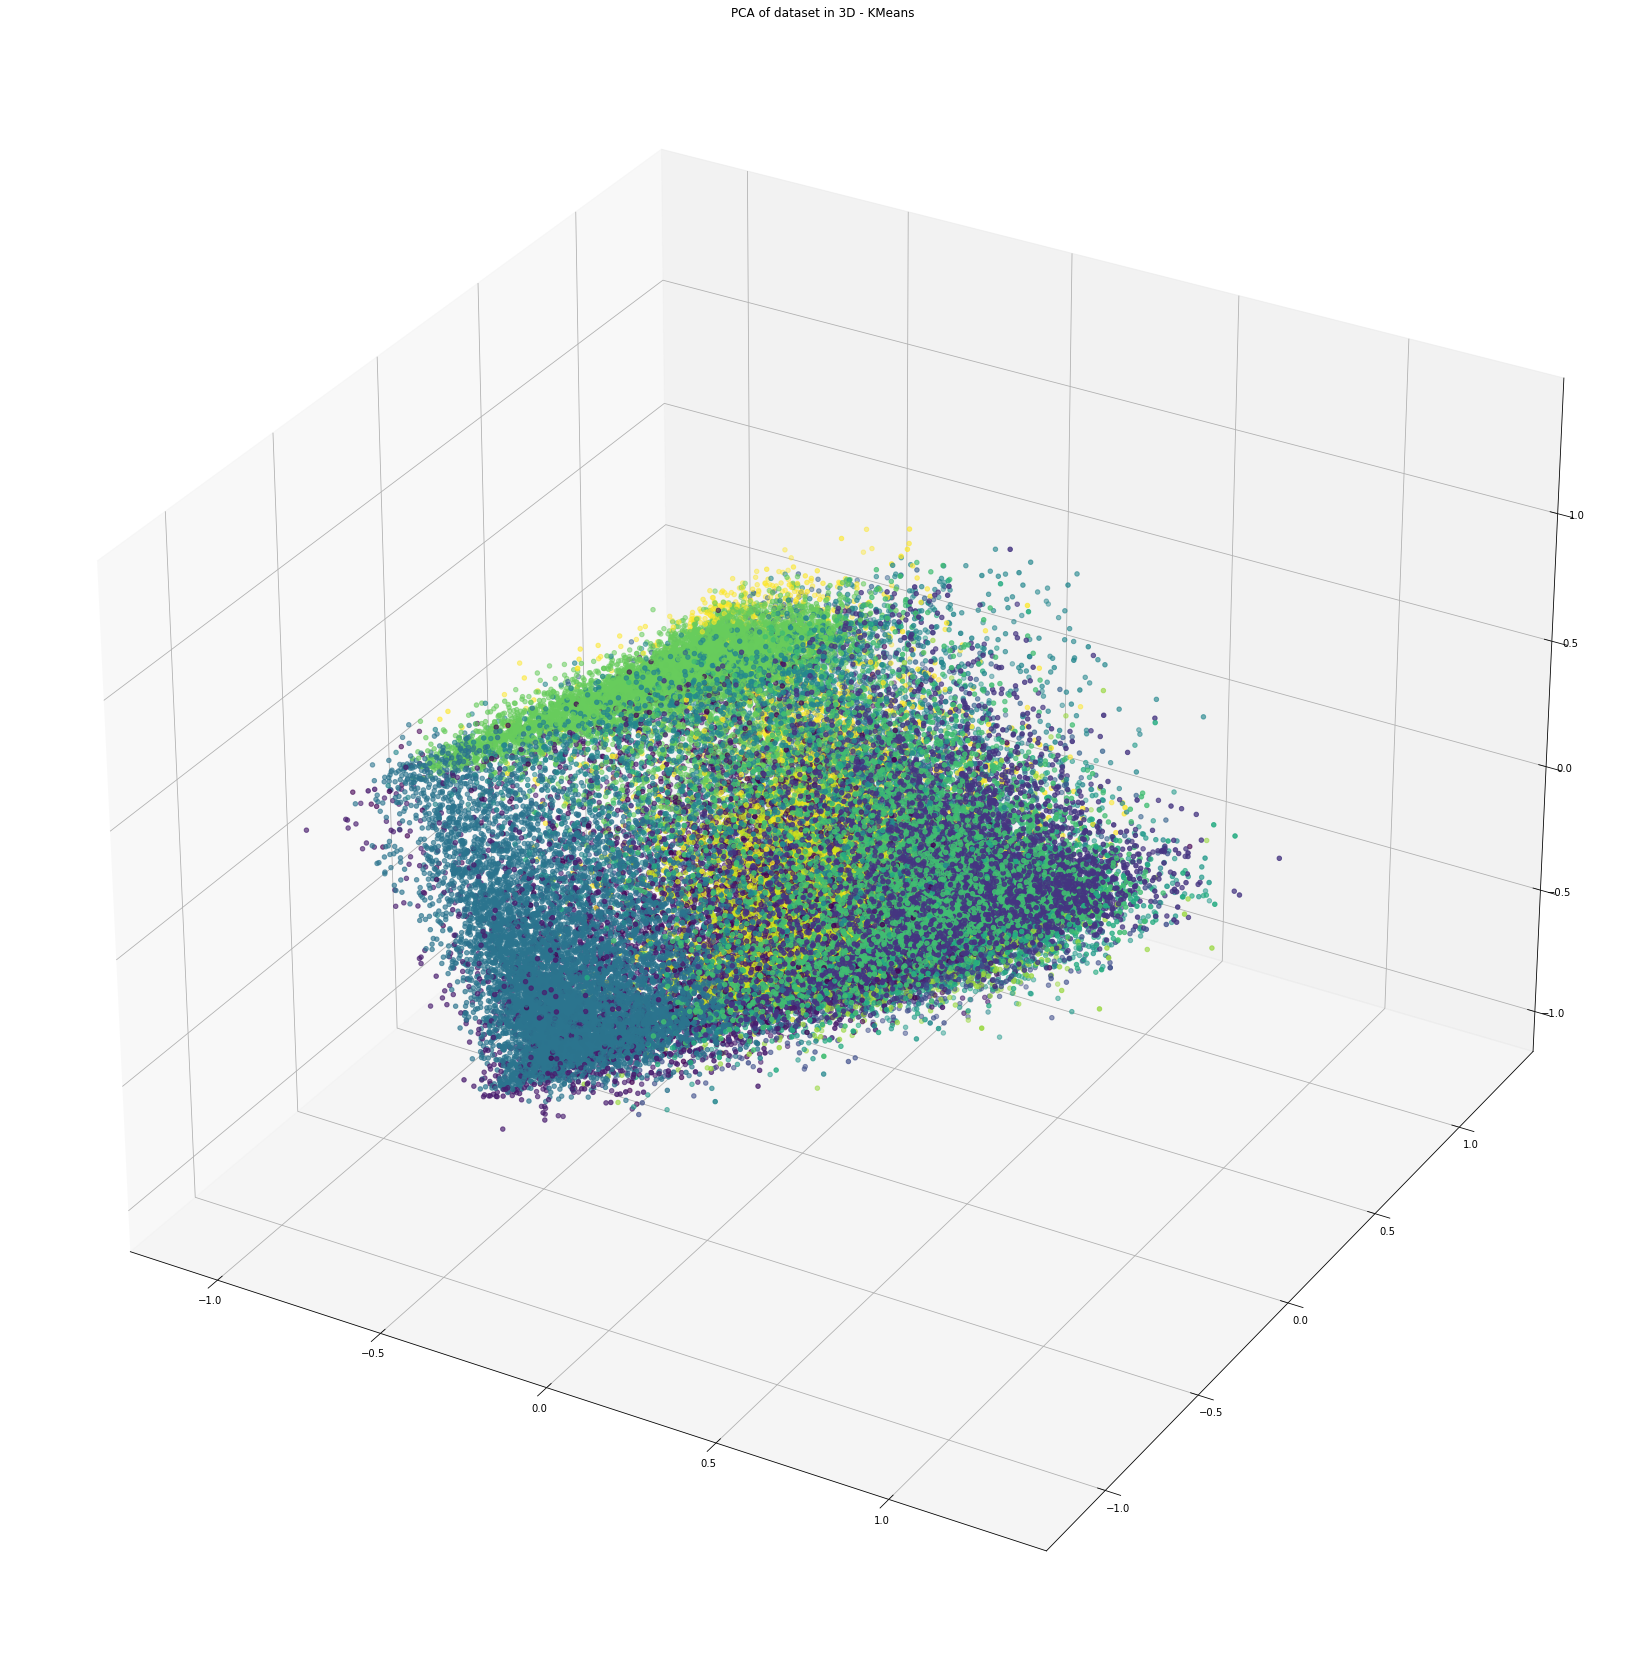

In [16]:
PCA_Visualisation(norm_clients_data,
                  cluster, 
                  cluster_centers,
                  method = 'KMeans',
                  threeD = threeD)

# SEGMENTATION HIERARCHICAL CLUSTERING

In [17]:
if do_Analysis:
    start = time()
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    dend = shc.dendrogram(shc.linkage(norm_clients_data.head(max_fitted), method=method),
                          p = 50,
                          truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [18]:
from sklearn.cluster import AgglomerativeClustering

start = time()

hierarchical_model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)  
hierarchical_model.fit(norm_clients_data.head(max_fitted))
print(hierarchical_model)
# 15s * (N/10k)²
print("Time Taken to fit/predict model : ~" + str(int(time() - start)) + "secondes")

AgglomerativeClustering(n_clusters=14)
Time Taken to fit/predict model : ~21secondes


In [19]:

start = time()

hierarchical_centroid   = [{c:0 for c in norm_clients_data.columns} for _ in range(K)]
hierarchical_cluster    = hierarchical_model.labels_
hierarchical_proportion = [0 for _ in range(K)]
for i in range(max_fitted):
    for c in norm_clients_data.columns:
        hierarchical_centroid[hierarchical_cluster[i]][c] += norm_clients_data[c][norm_clients_data.index[i]]
    hierarchical_proportion[hierarchical_cluster[i]]  += 1

for i in range(K):
    for c in norm_clients_data.columns:
        hierarchical_centroid[i][c] /= hierarchical_proportion[i]

hierarchical_interest = {i:[] for i in range(K)}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(hierarchical_centroid)):
    for c in norm_clients_data.columns:
        if hierarchical_centroid[i][c] > treshold:
            hierarchical_interest[i].append(c)

# environ 30s
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")

Time Taken to get interests : ~35secondes


In [20]:
NACK = 0

conn = engine.connect()
for key,values in hierarchical_interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = hierarchical_proportion[key]*100/max_fitted
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 20.2 %


Cluster 1: 5.57 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS     BAGUETTES
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS         PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES


Cluster 2: 11.33 %
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Cluster 3: 8.34 %
 Univ_KEY         Univ_1       Univ_2            Univ_3
      299 PETIT DEJEUNER VIENNOISERIE     VIENNOISERIES
      392  PRET A MANGER   SANDWICHES SANDWICHES FROIDS


Cluster 4: 9.71 %
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Cluster 5: 4.24 %
 Univ_KEY         Univ_1       Univ_2        Univ_3
      228       BOISSONS  SOFT DRINKS          SODA
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Cluster 6: 8.64 %
 Univ_KEY        Univ_1         Univ_2         Univ_3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07533066 0.06492658]
Time Taken to show PCA : ~0secondes


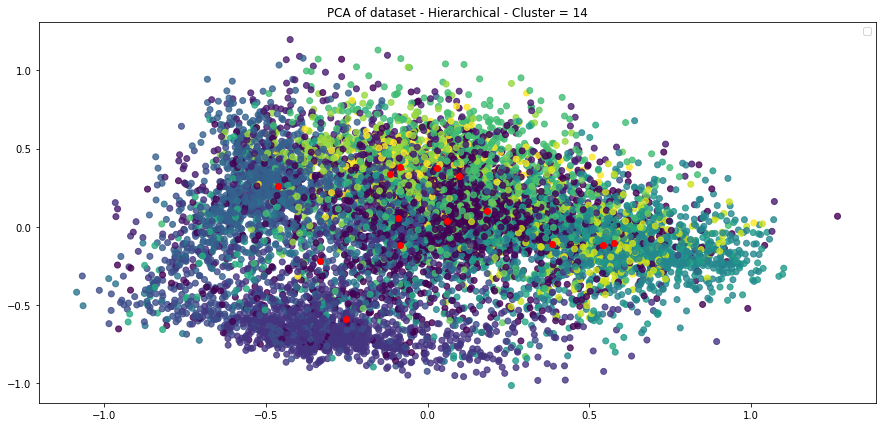

In [21]:
PCA_Visualisation(norm_clients_data.head(max_fitted), 
                  hierarchical_cluster,
                  [list(dic.values()) for dic in hierarchical_centroid],
                  method = 'Hierarchical',
                  threeD = threeD)

In [22]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~683secondes


## PCA Dimension reductor + KMeans

In [23]:
if do_Analysis:
    min_analyzed_dim = 0
    max_analyzed_dim = len(norm_clients_data.columns)
    
    model_pca = PCA(n_components= max_analyzed_dim)
    predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)
    
    total_coef = {i:1-sum(model_pca.explained_variance_ratio_[:i]) 
                  for i in range(min_analyzed_dim,max_analyzed_dim)}
    print(total_coef)
    plt.figure(figsize=(15, 7)) 
    plt.plot(total_coef.keys(), total_coef.values())
    plt.grid(True)
    plt.title('PCA Reduction : Quantitée Relative Perdue en fonction du nombre de dimension')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Reduction_Proportion.jpg")
    
    plt.show()
    

In [24]:
model_pca = PCA(n_components= nbr_dim_keep)
predict = model_pca.fit(norm_clients_data).transform(norm_clients_data)

In [25]:
new_datas = pd.DataFrame(index=norm_clients_data.index, data = predict)
print(new_datas)

              0         1         2         3         4         5         6   \
106621  0.578385  0.020124  0.294653 -0.083847 -0.008516 -0.320106  0.438219   
84256  -0.095364 -0.023613 -0.046301  0.784696 -0.303369 -0.043614 -0.435380   
37918   0.028505  0.368271 -0.472480  0.241465  0.183894 -0.232750 -0.319774   
59002   0.099556 -0.019710  0.424190  0.078896 -0.400802 -0.065169  0.157324   
75779   0.090280  0.178889 -0.465781 -0.158798 -0.254669 -0.007629 -0.045250   
...          ...       ...       ...       ...       ...       ...       ...   
2110   -0.021725  0.334269 -0.617998  0.478334  0.011106 -0.204911 -0.267936   
96071  -0.653254 -0.592501 -0.111708 -0.192686  0.061597  0.083213  0.034442   
18446  -0.273552  0.204008  0.178691 -0.251123 -0.358507  0.149581  0.060038   
75906  -0.252959 -0.522755 -0.695772  0.284098  0.012903  0.380833  0.195674   
14467  -0.007456  0.038618 -0.267392 -0.347510 -0.401969 -0.084976 -0.120018   

              7         8         9    

In [26]:
if do_Analysis:
    start = time()
    
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(new_datas)
        distorsions.append(model.inertia_)

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve after PCA')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve_after_PCA.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [27]:
if do_Analysis:
    start = time()

    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(new_datas)
        cluster = model.predict(new_datas)
        cluster_centers = model.cluster_centers_

        treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([int(c > treshold) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))

    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve after PCA')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve_after_PCA.jpg")
    
    plt.show()
    
    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [28]:
start = time()

model = KMeans(K_PCA, n_init = n_init)
model.fit(new_datas)

# environ 10s
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~22secondes


In [29]:
start = time()

PCA_centroid   = [{c:0 for c in norm_clients_data.columns} for _ in range(K_PCA)]
PCA_cluster    = model.labels_
PCA_proportion = [0 for _ in range(K_PCA)]

for i in range(len(norm_clients_data.index)):
    for c in norm_clients_data.columns:
        PCA_centroid[PCA_cluster[i]][c] += norm_clients_data[c][norm_clients_data.index[i]]
    PCA_proportion[PCA_cluster[i]]      += 1

for i in range(K_PCA):
    for c in norm_clients_data.columns:
        PCA_centroid[i][c] /= PCA_proportion[i]

PCA_interest = {i:[] for i in range(K_PCA)}

treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh

for i in range(len(PCA_centroid)):
    for c in norm_clients_data.columns:
        if PCA_centroid[i][c] > treshold:
            PCA_interest[i].append(c)

#environ 2min
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")
print(PCA_interest)

Time Taken to get interests : ~262secondes
{0: [405], 1: [299], 2: [322], 3: [296, 299], 4: [392], 5: [180], 6: [299, 294, 322, 405, 297, 392, 403, 228], 7: [405, 403], 8: [412, 408, 402], 9: [244], 10: [392, 228], 11: [], 12: [297], 13: [272]}


In [30]:
NACK = 0

conn = engine.connect()
for key,values in PCA_interest.items():
    print("\n\nCluster", key, end=': ')
    proportion = PCA_proportion[key]*100/len(cluster)
    print(round(proportion,2),"%",)
    
    if len(values) == 0:
        NACK += proportion
        continue
    
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
    ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
    ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
    FROM ['''+DB+'''].[DWH].[Dim_'''+TABLE_UNIVERS+''']
    WHERE '''
    for v in values:
        sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
    sql_command = sql_command[:-3]
    #print(sql_command)

    df_libele = pd.read_sql(sql_command, conn)
    print(df_libele.to_string(index=False))
conn.close()

print("\nNACK =", round(NACK,2),"%")



Cluster 0: 8.38 %
 Univ_KEY        Univ_1         Univ_2       Univ_3
      405 PRET A MANGER PLATS PREPARES ITALIAN FOOD


Cluster 1: 13.07 %
 Univ_KEY         Univ_1       Univ_2        Univ_3
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES


Cluster 2: 4.76 %
 Univ_KEY                     Univ_1                    Univ_2 Univ_3
      322 APERITIF   ENTREES   TAPAS BISCUITERIE SALEE  SNACKS  CHIPS


Cluster 3: 5.86 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES


Cluster 4: 12.94 %
 Univ_KEY        Univ_1     Univ_2            Univ_3
      392 PRET A MANGER SANDWICHES SANDWICHES FROIDS


Cluster 5: 5.3 %
 Univ_KEY           Univ_1  Univ_2         Univ_3
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES


Cluster 6: 4.69 %
 Univ_KEY                     Univ_1                       Univ_2            Univ_3
      228        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07434054 0.06302172]
Time Taken to show PCA : ~0secondes


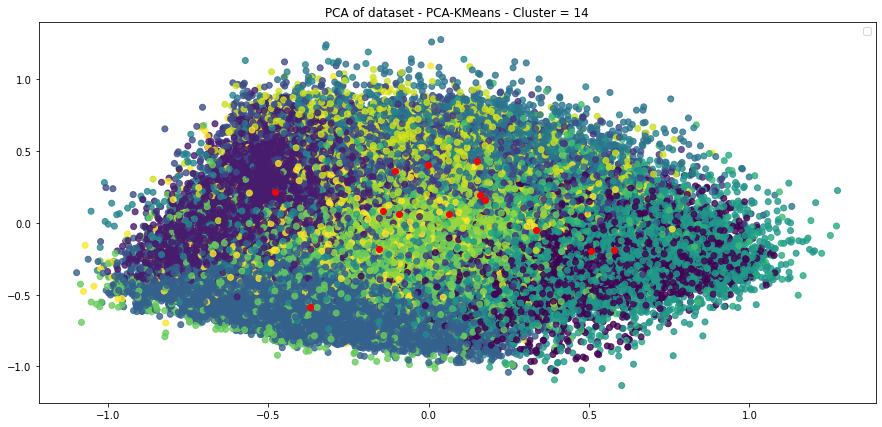

In [31]:
PCA_Visualisation(norm_clients_data, 
                  PCA_cluster, 
                  [list(dic.values()) for dic in PCA_centroid],
                  method = 'PCA-KMeans',
                  threeD = threeD)

In [32]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~985secondes


## Reconstruction des résultats du KMeans A LA MAIN

In [33]:
cluster_correspondance = {0:0, 1:1, 2:2, 3:3, 4:0, 5:1, 6:4,7:5, 8:6, 9:7, 10:0, 11:3, 12:0, 13:8}
new_cluster = []
for c in cluster:
    new_cluster.append(cluster_correspondance[c])
new_cluster_center = [[0 for _ in range(len(cluster_centers[0]))] for _ in range(9)]
cluster_proportion = [0 for _ in range(9)]
for i in range(len(cluster_centers)):
    cluster_proportion[cluster_correspondance[i]] += cluster.tolist().count(i)
    for j in range(len(cluster_centers[i])):
        new_cluster_center[cluster_correspondance[i]][j] += cluster_centers[i][j]*cluster.tolist().count(i)

for i in range(len(new_cluster_center)):
    for j in range(len(new_cluster_center[i])):
        new_cluster_center[i][j] /= cluster_proportion[i]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07434054 0.06302172]
Time Taken to show PCA : ~0secondes


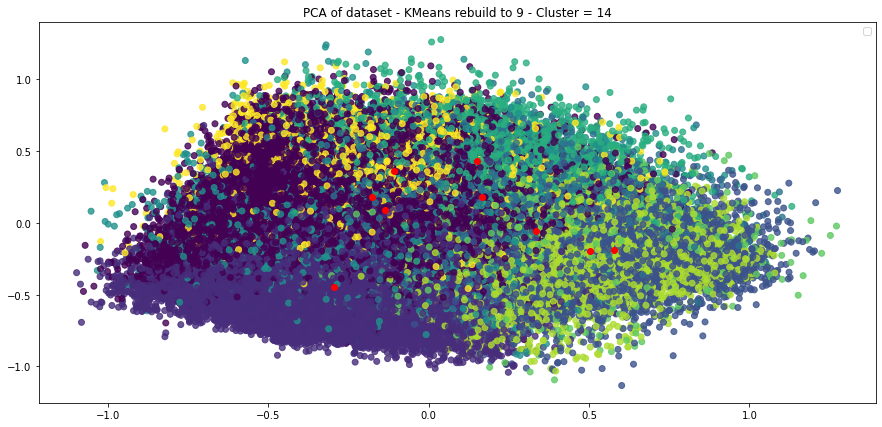

In [34]:
PCA_Visualisation(norm_clients_data, 
                  new_cluster, 
                  new_cluster_center, 
                  method = 'KMeans rebuild to 9', 
                  threeD = threeD)

In [35]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~994secondes


In [36]:
# conn = engine.connect()

# for i in range(len(cluster)):
#     sql_cmd = '''UPDATE  ['''+DB+'''].[DWH].[Dim_'''+TABLE_CONSO+''']
#     SET ['''+TABLE_CONSO+'''.Segment_Clientele] = ''' + str(cluster_correspondance[cluster[i]]) +''' 
#     WHERE ['''+TABLE_CONSO+'''.KEY] = ''' + str(norm_clients_data.index[i])
    
#     conn.execute(sql_cmd)
    
#     if not i % 1000:
#         print(i*100/len(cluster), "%")
# conn.close()

        158  278  271       224  288       142       244  334       437  267  \
106621  0.0  0.0  0.0  0.000000  0.0  0.000000  0.400000  0.0  0.000000  0.0   
84256   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
37918   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
59002   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.200000  0.0   
75779   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
...     ...  ...  ...       ...  ...       ...       ...  ...       ...  ...   
2110    0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.000000  0.0   
96071   0.0  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.0  0.391304  0.0   
18446   0.0  0.0  0.0  0.000000  0.0  0.100000  0.300000  0.0  0.000000  0.0   
75906   0.0  0.0  0.0  0.166667  0.0  0.333333  1.000000  0.0  0.000000  0.0   
14467   0.0  0.0  0.0  0.000000  0.0  0.000000  0.142857  0.0  0.000000  0.0   

        ...  34   312  108  325  155   

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07434054 0.06302172]
Time Taken to show PCA : ~0secondes


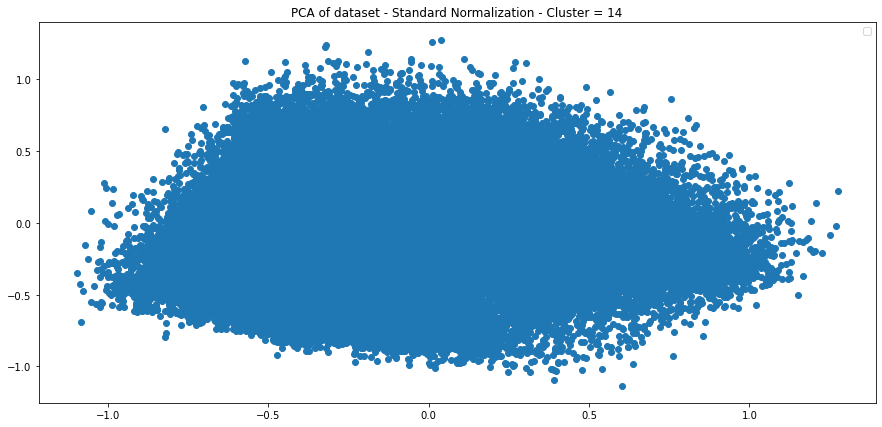

In [37]:
print(norm_clients_data)
PCA_Visualisation(norm_clients_data, method = 'Standard Normalization')